In [198]:
words = open('names.txt', 'r').read().splitlines()

In [ ]:
"""
Note that storing bigrams into a dictionary is highly inefficient,
and it is also not very scalable.
"""

words

b = {} # initialise dictionary

for n in words:
    char = ['<S>'] + list(n) + ['<E>'] # add starting and ending tags to identify start and end chars
    for ch1,ch2 in zip(char, char[1:]):
        bigram = ch1,ch2
        b[bigram] = b.get(bigram, 0) +1 # search b if bigram exists else initialise to 0, then add 1 to the key

b # print

In [ ]:
# Storing into a list is more efficient
sorted(b.items(), key = lambda kv : -kv[1])

In [ ]:
"""
The Bigram Method:
Using a 27x27 matrix to represent char1 x char2 bigram frequency count in dataset. This matrix will
be used to calculate the target loss function of the dataset, which we will try to match through using
the backpropagation.
"""

import torch

In [214]:
# Initialize a 27x27 torch matrix of zeros (26 alphabets + 1 ".")
N = torch.zeros((27,27) , dtype=torch.int32)

In [215]:
# Initialize the index of characters to index for the matrix
charset = sorted(set(''.join(words)))
charset.insert(0, ".")
stoi = { ltr: idx for idx, ltr in enumerate(charset) }
itos = { idx: ltr for idx, ltr in enumerate(charset) }

In [218]:
for n in words:
    char = ['.'] + list(n) + ['.'] # add starting and ending tags to identify start and end chars
    for ch1,ch2 in zip(char, char[1:]):
        axi1 = stoi[ch1]
        axi2 = stoi[ch2]
        N[axi1, axi2] += 1

In [202]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Visualize the frequency counts of <char1><char2> in the dataset
plt.figure(figsize=(16,16))
plt.imshow(N, cmap="Blues")
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        # ha = horizontal align, va = vertical align
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off')

In [219]:
N[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [209]:
P[1].sum()

tensor(1.)

In [220]:
# normalizing the dataset for 
P = (N+1).float()
P /= P.sum(1, keepdims=True)

# note that the arguments in sum are very important -> leads to very different results
# print(P.sum(1, keepdim=True).shape)
# print(P.sum(1).shape)
# print(P.sum().shape)

# additionally, take note of broadcasting rule
# here, we are dividing P, a 27x27 matrix, with P.sum(args), a 27x1 matrix
# in pytorch, broadcasting gives what we want, where the 27x1 matrix is "stretched"
# into a 27x27x matrix, where the inputs to the first col are copied to the other cols

In [ ]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  out = []
  ix = 0
  while True:
    p = P[ix]
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

In [213]:
for w in words[:3]:
    char = ['.'] + list(w) + ['.'] # add starting and ending tags to identify start and end chars
    for ch1,ch2 in zip(char, char[1:]):
        axi1 = stoi[ch1]
        axi2 = stoi[ch2]
        prob = P[axi1, axi2]
        print(f'{ch1}{ch2}: {prob:.4f}')

.e: 0.0478
em: 0.0377
mm: 0.0253
ma: 0.3885
a.: 0.1958
.o: 0.0123
ol: 0.0779
li: 0.1774
iv: 0.0152
vi: 0.3508
ia: 0.1380
a.: 0.1958
.a: 0.1376
av: 0.0246
va: 0.2473
a.: 0.1958


In [221]:
"""
This section helps us determine the "ground-truth" of our dataset, using the
log-likelihood estimator to calculate the "loss" for our dataset using the 
frequency of each bigram pairing.
In the subsequent backpropagation modules, we aim to train the model to obtain
a "loss" that is as close to the ground-truth as possible.
"""

log_likelihood = 0.0
n = 0

for w in words:
    char = ['.'] + list(w) + ['.'] # add starting and ending tags to identify start and end chars
    for ch1,ch2 in zip(char, char[1:]):
        axi1 = stoi[ch1]
        axi2 = stoi[ch2]
        prob = P[axi1, axi2]
        log_likelihood += torch.log(prob)
        n += 1
print("ll:",log_likelihood)
nll = - log_likelihood / n
print("nll:",nll)

ll: tensor(-559951.5625)
nll: tensor(2.4544)


In [238]:
"""
We start by creating the training set of input char x, and target char y
"""
xs = []
ys = []

for w in words[:1]:
    char = ['.'] + list(w) + ['.'] # add starting and ending tags to identify start and end chars
    for ch1,ch2 in zip(char, char[1:]):
        axi1 = stoi[ch1]
        axi2 = stoi[ch2]
        xs.append(axi1)
        ys.append(axi2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [239]:
xs

tensor([ 0,  5, 13, 13,  1])

In [240]:
ys

tensor([ 5, 13, 13,  1,  0])

In [241]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()
xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

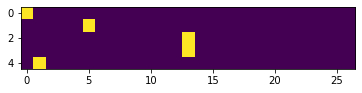

In [242]:
plt.imshow(xenc)

In [273]:
xenc.shape

torch.Size([5, 27])

In [279]:
# we first initialize a matrix with 1 column x 27 rows
# this is equivalent of our random weights in prev lesson
# we will backpropagate and optimize this W
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27), generator=g, requires_grad=True)

In [271]:
# conduct matrix multiplication with our xenc matrix dataset
logits = xenc @ W
counts = logits.exp() # this is equivalent to our N above
probability = counts / counts.sum(1, keepdim=True) # this and the above are
# the equiv of the 'softmax activation function'
probability

tensor([[0.0261, 0.0193, 0.0255, 0.0191, 0.0466, 0.0322, 0.0252, 0.0140, 0.1186,
         0.3459, 0.0165, 0.0041, 0.0035, 0.0074, 0.0115, 0.0521, 0.0104, 0.0105,
         0.0349, 0.0144, 0.0417, 0.0222, 0.0238, 0.0178, 0.0196, 0.0298, 0.0074],
        [0.0163, 0.0010, 0.0102, 0.0101, 0.0032, 0.0035, 0.0115, 0.0209, 0.0077,
         0.0902, 0.0742, 0.0592, 0.0722, 0.0414, 0.0497, 0.0566, 0.0383, 0.0175,
         0.0447, 0.1374, 0.0522, 0.0162, 0.0225, 0.0083, 0.0356, 0.0433, 0.0560],
        [0.0288, 0.0822, 0.0242, 0.0651, 0.0242, 0.0313, 0.0224, 0.0248, 0.0508,
         0.0132, 0.0185, 0.0435, 0.0208, 0.0459, 0.0203, 0.0200, 0.0723, 0.0315,
         0.0868, 0.0374, 0.1300, 0.0051, 0.0081, 0.0115, 0.0118, 0.0243, 0.0450],
        [0.0288, 0.0822, 0.0242, 0.0651, 0.0242, 0.0313, 0.0224, 0.0248, 0.0508,
         0.0132, 0.0185, 0.0435, 0.0208, 0.0459, 0.0203, 0.0200, 0.0723, 0.0315,
         0.0868, 0.0374, 0.1300, 0.0051, 0.0081, 0.0115, 0.0118, 0.0243, 0.0450],
        [0.0189, 0.0086,

In [277]:
# now, taking the original xs and ys inputs and targets, and our W
# matrix of predicted probabilities, we calculate the loss function
nlls = torch.zeros(5)
for i in range(5):
    x = xs[i].item()
    y = ys[i].item()
    prob = probability[i,y]
    logprob = torch.log(prob)
    negll = - logprob
    nlls[i] = negll
    print(f'nll of {itos[x]}{itos[y]}',negll)

nll of .e tensor(3.4361)
nll of em tensor(3.1850)
nll of mm tensor(3.0814)
nll of ma tensor(2.4983)
nll of a. tensor(3.9672)


In [ ]:
# --------------- full code here ---------------

In [282]:
# initialize dataset
xs, ys = [], []

for w in words:
    char = ['.'] + list(w) + ['.'] # add starting and ending tags to identify start and end chars
    for ch1,ch2 in zip(char, char[1:]):
        axi1 = stoi[ch1]
        axi2 = stoi[ch2]
        xs.append(axi1)
        ys.append(axi2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
numElements = xs.nelement()
print("number of training data:", numElements)

number of training data: 228146


In [283]:
# initialize neural net
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27), generator=g, requires_grad=True)

In [299]:
# gradient descent
for i in range(50):
    # forward pass
    xenc = F.one_hot(xs, num_classes=27).float()
    logits = xenc @ W
    counts = logits.exp() # this is equivalent to our N above
    probability = counts / counts.sum(1, keepdim=True) # this and the above are
    # the equiv of the 'softmax activation function'
    loss = -probability[torch.arange(numElements), ys].log().mean()
    print(f'loss is:{loss}')

    # backward pass
    W.grad = None # setting gradients to 0
    loss.backward()

    # perturbation
    W.data += -100 * W.grad

loss is:2.4576191902160645
loss is:2.4575998783111572
loss is:2.45758056640625
loss is:2.457561731338501
loss is:2.457542896270752
loss is:2.457524538040161
loss is:2.457505941390991
loss is:2.4574878215789795
loss is:2.4574697017669678
loss is:2.457451820373535
loss is:2.4574339389801025
loss is:2.457416534423828
loss is:2.457399368286133
loss is:2.4573822021484375
loss is:2.457365036010742
loss is:2.457348108291626
loss is:2.457331657409668
loss is:2.457314968109131
loss is:2.457298755645752
loss is:2.457282304763794
loss is:2.457266092300415
loss is:2.4572501182556152
loss is:2.4572346210479736
loss is:2.457218647003174
loss is:2.4572033882141113
loss is:2.457188129425049
loss is:2.4571728706359863
loss is:2.457157611846924
loss is:2.4571428298950195
loss is:2.4571282863616943
loss is:2.45711350440979
loss is:2.4570987224578857
loss is:2.4570844173431396
loss is:2.4570698738098145
loss is:2.4570560455322266
loss is:2.4570415019989014
loss is:2.4570281505584717
loss is:2.457014322280

In [294]:
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  
  out = []
  ix = 0
  while True:
    
    # ----------
    # BEFORE:
    #p = P[ix]
    # ----------
    # NOW:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------
    
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

junide.
janasah.
prelay.
a.
nn.
